# Laboratorio 1: Percepción remota

## Álvaro Paredes (alvaro.paredes@dataobservatory.net) | Javier Lopatin (javier.lopatin@uai.cl)

En este práctico vamos a ver cómo utilizar Jupyter Notebooks con Kernel de Python para cargar y visualizar imágenes satelitales del sensor Landsat 8.

Caracteristicas de las bandas de Landsat 8: https://www.usgs.gov/media/images/landsat-8-band-designations

![](https://www.usna.edu/Users/oceano/pguth/md_help/remote_sensing_course/Landsat.v.Sentinel-2.png)

![](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/Landsat%208%20band%20designations.jpg?itok=iMHeYQhF)

En primera instancia, vamos a instalar dependencias que la máquina vitual de Google Colab necesita para funcionar adecuadamente con nuestros datos. Estas librerias son:

- GDAL (Geospatial Data Abstraction Library): librería de algoritmos creados en C y C++ para manipular datos raster. Es la base para casi todas las librerias o software raster que existe. (https://gdal.org/)

- Geopandas: Librería Python para cargar y manipular datos vectoriales. Utiliza la misma estructura de datos que Pandas.(https://geopandas.org).

- Rasterio: Librería Python para manipular datos raster. (https://rasterio.readthedocs.io/).

- Xarray: Librería Python para manipular datos raster de forma similar a Numpy. Es cómodo cuando hay series temporales o datos repetitivos en la misma área. Gran parte del curso va a usar esta estructura de datos. (https://xarray.pydata.org/en/stable/).

- RioXarray: Librería que utiilza Rasterio para abrir datos raster en formato Xarray. (https://pypi.org/project/rioxarray/).

In [ ]:
%%capture
# Installations
!apt install gdal-bin python-gdal python3-gdal 
!pip install geopandas patool
!pip install xarray rasterio rioxarray

In [ ]:
# cargamos las librerias en el sistema
import pandas as pd
import geopandas as geopandas
import xarray as xr
import rioxarray as riox
import rasterio as rio
import patoolib
import os
import matplotlib.pyplot as plt

In [ ]:
# descargamos los datos necesarios para el laboratorio. La dirección de descarga puede ser cambiada
# alternativamente, pueden descargar y extraer los datos de forma manual en el PC
%%capture
!rm -R Lab01*
!wget https://github.com/alvaroparedesl/percepcion_remota/raw/main/Data/Lab01.rar
!mkdir Lab01
patoolib.extract_archive("Lab01.rar", outdir='Lab01')

patool: Extracting Lab01.rar ...
patool: running /usr/bin/unrar x -- /content/Lab01.rar
patool:     with cwd='Lab01'
patool: ... Lab01.rar extracted to `Lab01'.


In [ ]:
# creamos objeto con la dirección a nustra imágen Landsat 8. 
# normalmente cada banda de la imágen se guarda por separado, por lo que vamos a cargar sólo la B2, correspondiente al Azul
# https://www.usgs.gov/media/images/landsat-8-band-designations

fpath = 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B2.tif'

# como pueden ver en el nombre, la imágen corresponde a datos del 2019-09-20 (año-mes-día). El resto del código corresponde 
# a la zona de la imágen (en este caso valparaíso) y al tipo de datos. 
# es este caso, la imáges es de tipo L1. ¿Qué significa esto? 
# https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products


# función para cargar un raster a la memoria del sistema
def rasterio_open(f):
    return riox.open_rasterio(f)

# load
src_image = rasterio_open(fpath)
src_image

<xarray.DataArray (band: 1, y: 1090, x: 1463)>
[1594670 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.42e+05 2.42e+05 2.42e+05 ... 2.858e+05 2.858e+05
  * y            (y) float64 -3.653e+06 -3.653e+06 ... -3.686e+06 -3.686e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [ ]:
# las imagenes tienen mucha información distinta. Por ejemplo se pueden ver los valores numericos como un array de Numpy
src_image.values

# estos valores en general van entre 0 y 10.000. Por que no entre 0 - 1 como debería ser la refrectancia? 
# es simplemente por un tema de almacenaje: guardar datos numéricos como enteros (inter) ocupa menos espacio físico que datos decimales (float) 

array([[[   0,    0,    0, ..., 8692, 9144, 9001],
        [   0,    0,    0, ..., 9234, 9296, 9207],
        [   0,    0,    0, ..., 9196, 9264, 9291],
        ...,
        [   0,    0,    0, ..., 8896, 8869, 8837],
        [   0,    0,    0, ..., 8885, 8890, 8889],
        [   0,    0,    0, ..., 8936, 8966, 8973]]], dtype=uint16)

In [1]:
# podemos usar la funcion plot de Xarray para ver la imagen de la B2.
# la opción robust=True permite no considerer outliars o valores extremos en la espaca de colores.
# las paletas de colores se pueden cambiar usando las de matplotlib: https://matplotlib.org/stable/tutorials/colors/colormaps.html

src_image.plot(figsize=(10, 10), robust=True, vmin=3000)

NameError: ignored

## Leer todas las bandas

Hay varis opciones para cargar todas las bandas a un sólo objeto en Python. Una alternativa es cargarlas una por una usando un _**for loop**_ y unirlas posteriormente.

In [ ]:
import glob # librería glob para leer todos los archivos en una carpeta 
from datetime import datetime # usar datetime para agregar información de fechas al objeto xarray. Teoricamente solo importante cuando tenemos datos temporales.

In [ ]:
# hacer lista de archivos en carpeta con extención .TIF
bands_names = glob.glob('Lab01/Imagen_Landsat/*.tif')
bands_names.sort() # ordenar por nombre
bands_names # ver lista

['Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B1.tif',
 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B10.tif',
 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B11.tif',
 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B2.tif',
 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B3.tif',
 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B4.tif',
 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B5.tif',
 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B6.tif',
 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B7.tif',
 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B8.tif',
 'Lab01/Imagen_Landsat/LC08_L1TP_233083_20190920_20190926_01_T1_B9.tif']

In [ ]:
# Las bandas para que esten ordenadas de forma asendente según su longitud de onda deben tener el siguiente orden:
band_order = ["B1", "B2", "B3", "B4", "B5", "B6", "B7"]

# Las bandas 8, 9, 10 y 11 no se consideran ¿por qué?

In [ ]:
# cargar archivos a una lista
bandsi = [rasterio_open(f).squeeze(drop=True) for f in bands_names]

# ejemlo de la primera imágen cargada a la lista () 
bandsi[1]

<xarray.DataArray (y: 1090, x: 1463)>
[1594670 values with dtype=uint16]
Coordinates:
  * x            (x) float64 2.42e+05 2.42e+05 2.42e+05 ... 2.858e+05 2.858e+05
  * y            (y) float64 -3.653e+06 -3.653e+06 ... -3.686e+06 -3.686e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [ ]:
# extraemos el nombre de cada banda usando los últimos caracteres, después de "_", de la lista
for i, im in enumerate(bandsi):
  bandsi[i].name = bands_names[i].split("_")[-1].split('.')[0]

# Filtramos según el orden y las bandas que definimos anteriormente:
bandsif = [f for b in band_order for f in bandsi if b == f.name]

In [ ]:
# unir todas las bandas en un objeto
image = xr.merge(bandsif)
image

<xarray.Dataset>
Dimensions:      (x: 1463, y: 1090)
Coordinates:
  * x            (x) float64 2.42e+05 2.42e+05 2.42e+05 ... 2.858e+05 2.858e+05
  * y            (y) float64 -3.653e+06 -3.653e+06 ... -3.686e+06 -3.686e+06
    spatial_ref  int64 0
Data variables:
    B1           (y, x) uint16 ...
    B2           (y, x) uint16 ...
    B3           (y, x) uint16 ...
    B4           (y, x) uint16 ...
    B5           (y, x) uint16 ...
    B6           (y, x) uint16 ...
    B7           (y, x) uint16 ...
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [ ]:
image = image.expand_dims({'time': [datetime.strptime('2019-09-20T14:33:58.942282', '%Y-%m-%dT%H:%M:%S.%f')]})
image

<xarray.Dataset>
Dimensions:      (time: 1, x: 1463, y: 1090)
Coordinates:
  * time         (time) datetime64[ns] 2019-09-20T14:33:58.942282
  * x            (x) float64 2.42e+05 2.42e+05 2.42e+05 ... 2.858e+05 2.858e+05
  * y            (y) float64 -3.653e+06 -3.653e+06 ... -3.686e+06 -3.686e+06
    spatial_ref  int64 0
Data variables:
    B1           (time, y, x) uint16 0 0 0 0 0 0 ... 9704 9593 9612 9609 9635
    B2           (time, y, x) uint16 0 0 0 0 0 0 ... 9109 8943 8936 8966 8973
    B3           (time, y, x) uint16 0 0 0 0 0 0 ... 8643 8410 8427 8478 8528
    B4           (time, y, x) uint16 0 0 0 0 0 0 ... 8871 8564 8481 8574 8581
    B5           (time, y, x) uint16 0 0 0 0 0 ... 14563 14698 14662 14815 14943
    B6           (time, y, x) uint16 0 0 0 0 0 ... 16174 15465 15267 15286 15313
    B7           (time, y, x) uint16 0 0 0 0 0 ... 12651 11947 11840 11912 11875
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [ ]:
# Ver sistema de coordenadas asignada a los datos
print(image.rio.crs)

EPSG:32619


Los sistemas de coordenadas tienen un código numerico EPSG asociado: https://epsg.io/

Por ejemplo: WGS 84 / UTM zone 19S = EPSG:32719

In [ ]:
# se puede cambiar el sistema de coordenadas de la imagen usando la función rio.reproject
imager = image.rio.reproject("EPSG:32719") # tambien puede ser rio.reproject(32719)
print(imager.rio.crs)

EPSG:32719


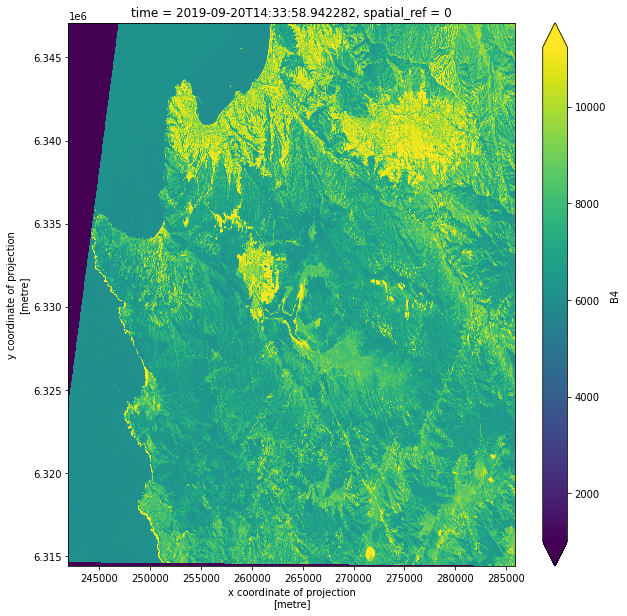

In [ ]:
# plot de la banda 4
imager.B4.isel(time=0).plot(figsize=(10, 10), robust=True, vmin=1000)

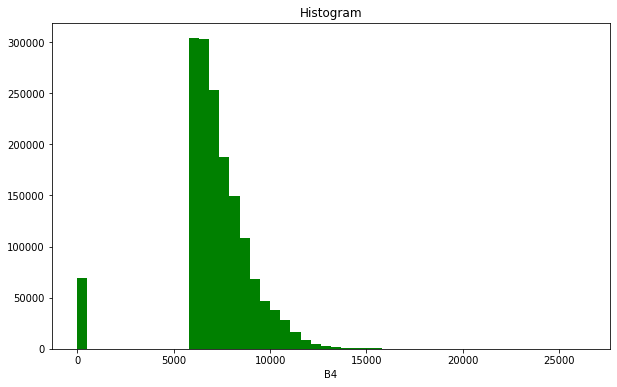

In [ ]:
# podemos ver el histograma de valores de la banda 4
histb4 = imager.B4.plot.hist(figsize=(10,6), color="green", bins=50)

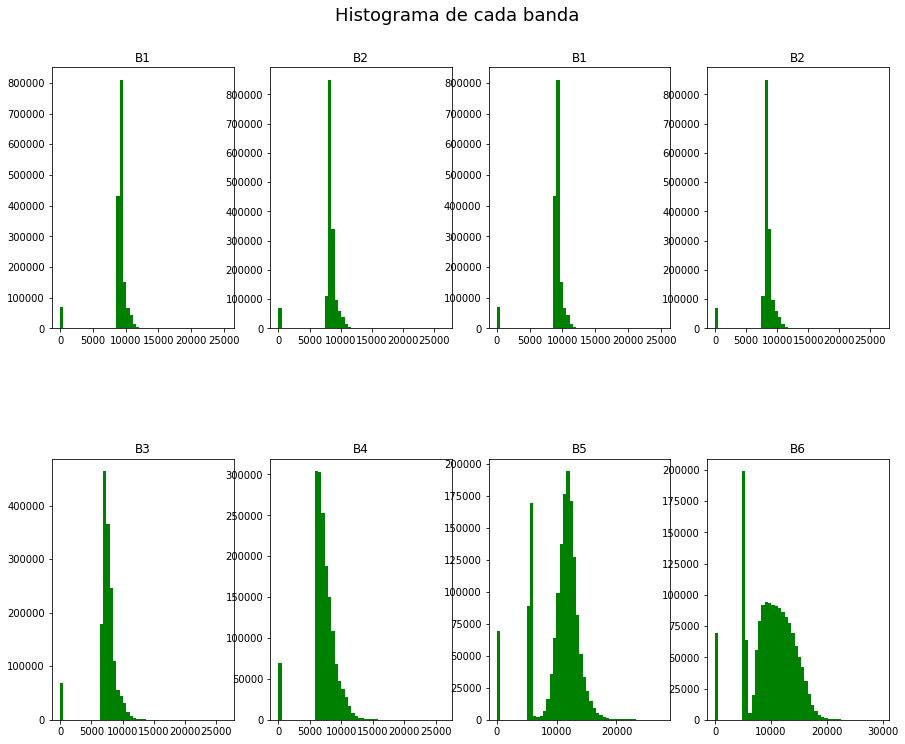

In [ ]:
# Ahora un histograma por banda
fig, axs = plt.subplots(2, 4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Histograma de cada banda", fontsize=18, y=0.95)

for band, ax in zip(band_order, axs.ravel()):
    imager[band].plot.hist(ax=ax, bins=50, color="green")
    ax.set_title(band)
    ax.set_xlabel("")

plt.show()

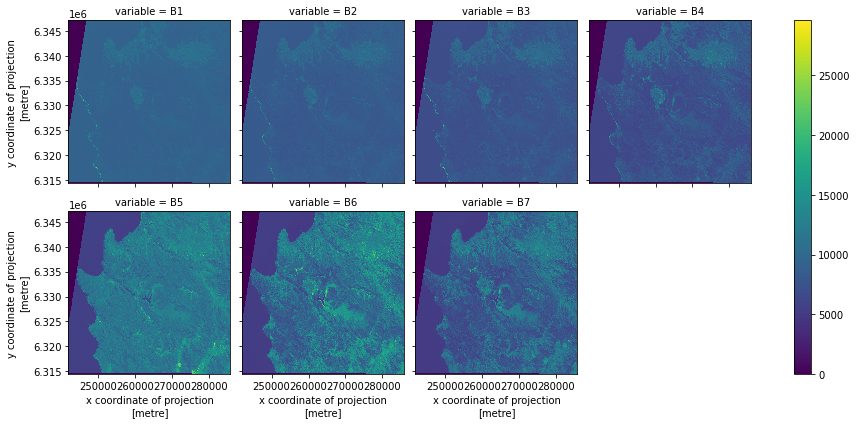

In [ ]:
# hacer plot de todas las bandas por separado manteniendo la misma escala de colores. ¿Qué bandas o zonas del espectro tienen menos reflectancia? 
imager.isel(time=0).to_array().plot(col="variable", col_wrap=4)

In [ ]:
# Enmascarar los valores que no son número (valores = 0) ¿qué problemas podría traer esto?
imager = imager.where(imager != 0)

# Pruebe el gráfico anterior con los valores enmascarados ¿qué cambia? ¿qué pasas con los histogramas?

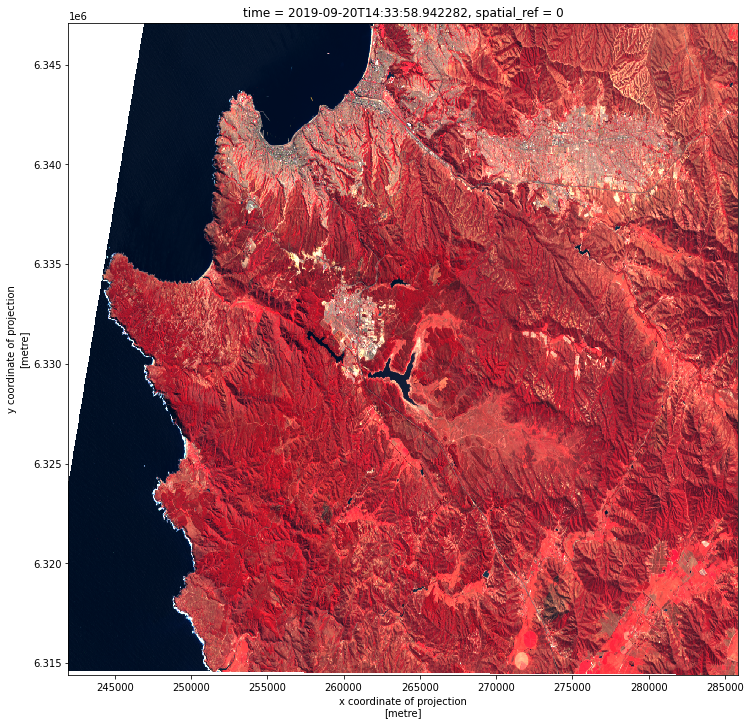

In [ ]:
# Visualizar en colores
imager[["B5", "B4", "B3"]].isel(time=0).to_array().plot.imshow(
    robust=True, figsize=(12, 12)
)

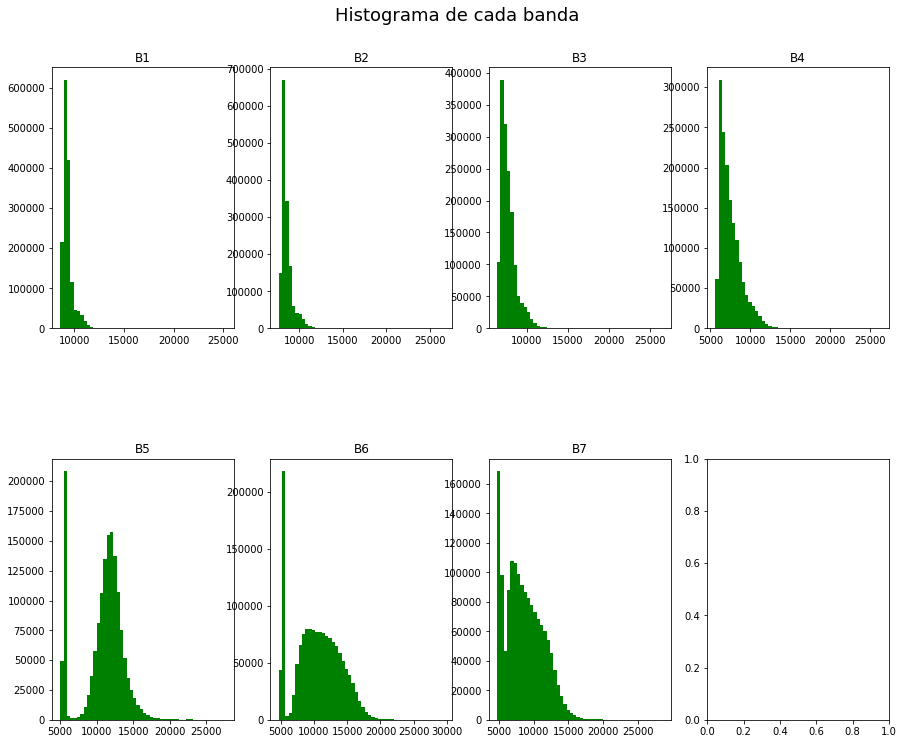

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Histograma de cada banda", fontsize=18, y=0.95)

for band, ax in zip(band_order, axs.ravel()):
    imager[band].plot.hist(ax=ax, bins=50, color="green")
    ax.set_title(band)
    ax.set_xlabel("")

plt.show()

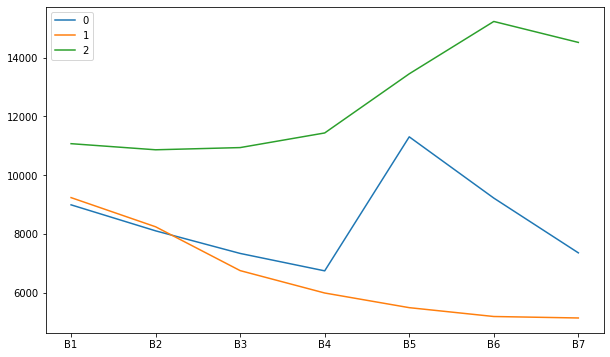

In [ ]:
# Ver puntos de interés y extraer la firma espectral
x_ = xr.DataArray([265000, 245000, 275000])
y_ = xr.DataArray([6335000, 6320000, 6340000])
firmas = imager.isel(time=0).sel(x=x_, y=y_, method="nearest").to_array().values
firmas = pd.DataFrame(firmas, index=list(imager.keys()))
firmas.plot(figsize=(10,6))